<a href="https://colab.research.google.com/github/aaahza/Toxicity-Model/blob/main/Toxicity_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing Data

In [23]:
df = pd.read_csv('/content/drive/MyDrive/train.csv')
x = df['comment_text']
y = df[df.columns[2:]].values

Preprocessing our data

In [21]:
from tensorflow.keras.layers import TextVectorization

In [22]:
MAX_FEATURES = 200000 # number of words in the vocab
vectorizer = TextVectorization(max_tokens=MAX_FEATURES, output_sequence_length=1800, output_mode='int')

In [24]:
vectorizer.adapt(x.values)
vectorized_text = vectorizer(x.values)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle((160000))
dataset = dataset.batch(16)
datatset = dataset.prefetch(8)

train = dataset.take(int(len(dataset) * .7))
val = dataset.skip(int(len(dataset) * .7)).take(int(len(dataset) * .2))
test = dataset.skip(int(len(dataset) * .9)).take(int(len(dataset) * .1))

Sequential Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Embedding, Dense

In [ ]:
model = Sequential()
model.add(Embedding(MAX_FEATURES + 1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))

model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')
model.summary()
history = model.fit(train, epochs=10, validation_data=val)
model.save('toxicity.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('toxicity2.keras')


In [ ]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

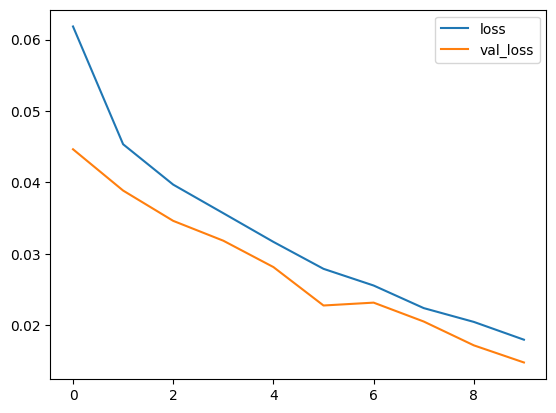

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

Predicting outcomes

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()
input_text = vectorizer('You freaking suck! I am going to hit you.')
res = model.predict(np.expand_dims(input_text, 0))

1/1 [==============================] - 2s 2s/step


In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
res

array([[0.9985713 , 0.3397576 , 0.9889669 , 0.01442496, 0.94756603,
        0.0426025 ]], dtype=float32)

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 62ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 1],
       [1, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]])

Model Evaluation

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  x_true, y_true = batch
  yhat = model.predict(x_true)

  y_true = y_true.flatten()
  yhat = yhat.flatten()

  pre.update_state(y_true, yhat)
  re.update_state(y_true, yhat)
  acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 63ms/step


In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9168345332145691, Recall:0.9234782457351685, Accuracy:0.5115346312522888


Gradio Application

In [11]:
!pip install gradio

In [12]:
import tensorflow as tf
import gradio as gr

In [ ]:
model.save('toxicity.h5')

In [7]:
model = tf.keras.models.load_model('/content/drive/MyDrive/toxicity.h5')

In [ ]:
input_str = vectorizer('hey i freaken hate you! I am coming to hunt you down')
res = model.predict(np.expand_dims(input_str, 0))
df.columns[2:]

1/1 [==============================] - 1s 1s/step


Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [ ]:
res

array([[0.76130915, 0.01316173, 0.06369994, 0.08797923, 0.08570859,
        0.09191837]], dtype=float32)

In [28]:
def score_comment(comment):
  vectorized_comment = vectorizer([comment])
  results = model.predict(vectorized_comment)

  text = ''
  for idx, col in enumerate(df.columns[2:]):
    text += '{}: {}\n'.format(col, results[0][idx] > 0.5)

  return text

In [29]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [30]:
interface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://0ed696040ba15fc1c0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 55ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://0ed696040ba15fc1c0.gradio.live


In [20]:
interface.close()

Closing server running on port: 7860
